# Exercise set 7: Signal processing

The main goal of this exercise is to gain practical experience with signal processing techniques used for preprocessing, for instance, of Near-Infrared (NIR) spectra. Preprocessing methods are important for improving the signal-to-noise ratio, correcting for scattering effects (variations in light path due to particle size, etc.), and enhancing spectral features, which can lead to more reliable analysis and development of robust predictive models. In addition, you will see how we can smooth noisy signals and calculate the derivative of a noisy signal.

**Learning Objectives:**

After completing this exercise set, you will be able to:

- Preprocess spectra by normalisation, multiplicative scatter correction, or taking a second derivative.
- Create a spline to smooth a signal and compute its derivative.

**To get the exercise approved, complete the following problems:**

- [7.1(a)](#7.1(a)) and at least one of [7.1(b)](#7.1(b)), [7.1(c)](#7.1(c)), or [7.1(d)](#7.1(d)): To show that you can apply preprocessing to NIR spectra.
- [7.2(a)](#7.2(a)) and [7.2(c)](#7.2(c)): To show that you can create a B-spline to smooth a signal and compute its derivative.

## Exercise 7.1 Preprocessing NIR spectra

We will analyze NIR spectra from two distinct Ethiopian [sorghum](https://en.wikipedia.org/wiki/Sorghum) cultivars to determine if they can be differentiated. Specifically, we will examine how different preprocessing techniques impact the outcome of a principal component analysis (PCA) applied to the spectra. 

**Note:**

1. The dataset used in this exercise is derived from [Kosmowski and Worku
](https://doi.org/10.1371/journal.pone.0193620) who used a miniaturised NIR spectrometer to identify Ethiopian crop cultivars. To simplify the analysis, we focus on measurements from only two of the ten sorghum cultivars studied in the original work

2. This exercise will mainly ask you to run and observe results from already implemented code.

### 7.1(a)

The following code performs these steps:

1. Load the NIR spectra from the data file [nir.csv](./nir.csv).
2. Extracts wavelengths, spectra, and cultivar names.
3. Defines colors for plotting cultivars.
4. Creates a function to plot spectra by cultivar.
5. Creates a function to run a PCA on provided spectra and plot the scores of the first two principal components.
6. Initializes a figure for results.
7. Plots the original spectra and the PCA results.

**Task: Execute the code and observe the generated plot. In the PCA scores plot, are there any noticeable groupings that suggest cultivar separation?**

In [185]:
# Load the needed libraries
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from scipy.signal import savgol_filter

%matplotlib inline
sns.set_theme(style="ticks", context="notebook", palette="colorblind")

# Load the raw data:
data = pd.read_csv("nir.csv")
data.head()

,Cultivator,740,741,742,743,744,745,746,747,748,...,1061,1062,1063,1064,1065,1066,1067,1068,1069,1070
0,Teshale,1.583638,1.584304,1.585249,1.586238,1.587157,1.587941,1.588644,1.589273,1.589877,...,1.696155,1.694503,1.693597,1.693636,1.694325,1.695350,1.695663,1.695113,1.694251,1.694145
1,Teshale,1.698067,1.699163,1.700438,1.701653,1.702705,1.703553,1.704275,1.704899,1.705492,...,1.792049,1.790300,1.789340,1.789382,1.790111,1.791196,1.791530,1.790951,1.790044,1.789934
2,Teshale,1.541099,1.541762,1.542684,1.543644,1.544539,1.545315,1.546026,1.546682,1.547332,...,1.684319,1.682712,1.681839,1.681902,1.682607,1.683641,1.683968,1.683433,1.682587,1.682489
3,Teshale,1.659987,1.660405,1.661149,1.661980,1.662780,1.663477,1.664119,1.664703,1.665270,...,1.758954,1.757223,1.756267,1.756295,1.756997,1.758049,1.758366,1.757787,1.756887,1.756771
4,Teshale,1.572186,1.572829,1.573675,1.574519,1.575277,1.575914,1.576498,1.577046,1.577610,...,1.691143,1.689509,1.688616,1.688665,1.689360,1.690388,1.690707,1.690163,1.689308,1.689206


In [186]:
data.describe(include='all') #'object' -> only non-numeric columns 

,Cultivator,740,741,742,743,744,745,746,747,748,...,1061,1062,1063,1064,1065,1066,1067,1068,1069,1070
count,100,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
unique,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,Teshale,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,1.624637,1.625286,1.626094,1.626904,1.627651,1.628309,1.628924,1.629509,1.630088,...,1.736170,1.734945,1.733980,1.733580,1.733732,1.734159,1.734487,1.734500,1.734402,1.734678
std,NaN,0.070099,0.070053,0.069997,0.069939,0.069878,0.069816,0.069753,0.069691,0.069631,...,0.051459,0.051691,0.051647,0.051388,0.051099,0.050806,0.050820,0.051111,0.051545,0.051789
min,NaN,1.530302,1.530620,1.531272,1.532041,1.532818,1.533537,1.534237,1.534910,1.535587,...,1.667199,1.665587,1.664707,1.664756,1.665443,1.666459,1.666776,1.666242,1.665401,1.665302
25%,NaN,1.557000,1.556970,1.557831,1.558707,1.559542,1.560314,1.561056,1.561777,1.562486,...,1.685718,1.684063,1.683150,1.683178,1.683852,1.684868,1.685194,1.684659,1.683813,1.683716
50%,NaN,1.625122,1.625282,1.625368,1.625574,1.625870,1.626243,1.626697,1.627222,1.627782,...,1.736161,1.735757,1.734814,1.733795,1.733141,1.732653,1.733044,1.734016,1.735191,1.736109
75%,NaN,1.699099,1.700176,1.701429,1.702619,1.703646,1.704469,1.705163,1.705759,1.706324,...,1.789182,1.788571,1.787548,1.786860,1.785940,1.784626,1.785062,1.786865,1.787920,1.787763


In [187]:
print(data.loc[:,'Cultivator'].value_counts())
print(data.loc[:,'Cultivator'].unique())
print(data.loc[:,'Cultivator'].nunique())

Cultivator
Teshale          50
Gambella_1107    50
Name: count, dtype: int64
['Teshale' 'Gambella_1107']
2


In [188]:
# Extract information from the data

variables = [i for i in data.columns if i != "Cultivator"] #wavelengths 
# Wavelengths as numbers:
wavelengths = np.array([float(i) for i in variables])
print(f"Number of wavelengths {len(wavelengths)}")
# All spectra as a data matrix:
all_spectra = data[variables].to_numpy()
print(f"Size of data matrix: {all_spectra.shape}")
# Name of the two cultivators:
cultivators = data["Cultivator"].unique()
print("Cultivators:", cultivators)

Number of wavelengths 331
Size of data matrix: (100, 331)
Cultivators: ['Teshale' 'Gambella_1107']


In [189]:
# Define a color mapping for the two cultivators:
colors = sns.color_palette("colorblind", n_colors=len(cultivators))
color_mapping = {key: colori for key, colori in zip(cultivators, colors)}
# Show the two colors
colors

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549)]

In [190]:
def plot_spectra(
    data, X, wavelengths, cultivators, color_mapping, axi, legend=False
):
    """

    Plots NIR spectra from the given data matrix X, color-coded by cultivar.

    Args:
        data (pandas.DataFrame): DataFrame containing cultivar information.
        X (numpy.ndarray): Matrix of NIR spectra, where each row is a spectrum.
        wavelengths (numpy.ndarray): Array of corresponding wavelengths for the spectra.
        cultivators (list): List of unique cultivar names.
        color_mapping (dict): Dictionary mapping cultivar names to colors.
        axi (matplotlib.axes.Axes): Matplotlib Axes object for plotting.
        legend (bool, optional): Whether to include a legend. Defaults to False.

    Returns:
        None (plots directly to the provided Axes object).
    """
    handles, labels = (
        [],
        [],
    )  # Initialize empty lists to store legend handles and labels
    for cultivator in cultivators:
        # Filter spectra belonging to the current cultivar
        spectra_cult = X[data["Cultivator"] == cultivator]
        for spectrum in spectra_cult:
            # Plot each spectrum with the assigned color
            (linei,) = axi.plot(
                wavelengths, spectrum, color=color_mapping[cultivator]
            )
        # Append the line handle and cultivar label for the legend
        handles.append(linei)
        labels.append(cultivator)
    if legend:
        # Add a legend to the plot if 'legend' is True
        legend = axi.legend(handles, labels, title="Cultivator:")

In [191]:
def run_pca_plot_scores(data, X, axi, cultivators, color_mapping):
    """
    Performs Principal Component Analysis (PCA) on the input spectra and plots the scores (color-coded).

    Args:
        data (pandas.DataFrame): DataFrame containing cultivar information.
        X (numpy.ndarray): Matrix of NIR spectra, where each row is a spectrum.
        axi (matplotlib.axes.Axes): Matplotlib Axes object for plotting.
        cultivators (list): List of unique cultivar names.
        color_mapping (dict): Dictionary mapping cultivar names to colors.

    Returns:
        None (plots directly to the provided Axes object).
    """
    pca = PCA(n_components=2)  # Initialize PCA with 2 components
    scores = pca.fit_transform(X)  # Perform PCA and get the scores

    for cultivator in cultivators:
        # Filter scores for the current cultivar
        xscores = scores[data["Cultivator"] == cultivator, 0]
        yscores = scores[data["Cultivator"] == cultivator, 1]

        # Plot the scores as a scatter plot
        axi.scatter(
            xscores, yscores, color=color_mapping[cultivator], label=cultivator, facecolor='none', 
        )
    # Calculate explained variance ratios
    perc = pca.explained_variance_ratio_ * 100
    # Set axis labels with explained variance percentages
    axi.set_xlabel(f"Scores PC1 ({perc[0]:.2f}%)")
    axi.set_ylabel(f"Scores PC2 ({perc[1]:.2f}%)")

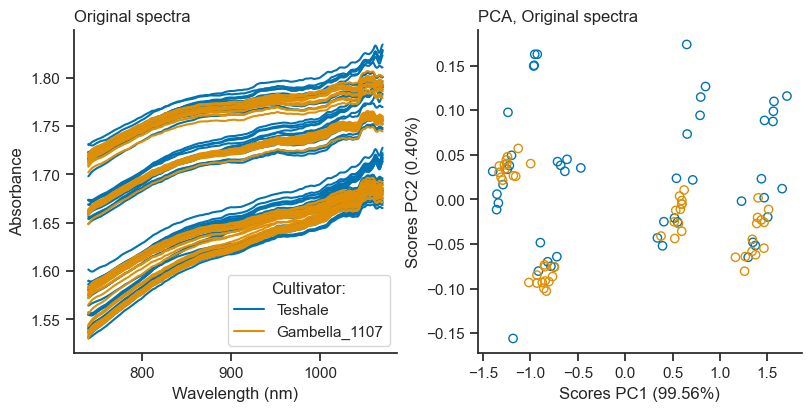

In [192]:
figure1, axes1 = plt.subplots(constrained_layout=True, ncols=2, figsize=(8, 4))

plot_spectra(
    data,
    all_spectra,
    wavelengths,
    cultivators,
    color_mapping,
    axes1[0],
    legend=True,
)
run_pca_plot_scores(data, all_spectra, axes1[1], cultivators, color_mapping)

axes1[0].set_xlabel("Wavelength (nm)")
axes1[0].set_ylabel("Absorbance")
axes1[0].set_title("Original spectra", loc="left")
axes1[1].set_title("PCA, Original spectra", loc="left")
sns.despine(fig=figure1)

#### Your answer to question 7.1(a): Is there a clear cultivar separation in the scores plot?
*Double click here*

Nope, but there are maybe three (?, or four?) groups -- all containing both cultivars -- along PC1. 

### 7.1(b)

**Task: Observe the impact of normalisation on the spectra and PCA results. In the PCA scores plot, are there any noticeable groupings that suggest cultivar separation?**

**Hint:**
1. Apply the provided normalization function to scale the spectra to the range $[-1, 1]$, for instance,
```python
normed = normalise_spectra(all_spectra)
```
2. Plot the normalised spectra and the corresponding PCA results side-by-side. For instance,
```python
figure2, axes2 = plt.subplots(constrained_layout=True, ncols=2, figsize=(8, 4))
plot_spectra(data, normed, wavelengths, cultivators, color_mapping, axes2[0])
run_pca_plot_scores(data, normed, axes2[1], cultivators, color_mapping)
```

In [193]:
from sklearn.preprocessing import MinMaxScaler


def normalise_spectra(spectra):
    """
    Normalises the given spectra using MinMaxScaler, scaling each spectrum to the range [-1, 1].

    Args:
        spectra (numpy.ndarray): Matrix of spectra, where each row is a spectrum.

    Returns:
        numpy.ndarray: Normalised spectra matrix.
    """
    scaled = np.zeros_like(spectra)
    for i, spectrum in enumerate(spectra):
        scaler = MinMaxScaler(feature_range=(-1, 1))
        scaled[i] = scaler.fit_transform(spectrum.reshape(-1, 1)).flatten()
    return scaled

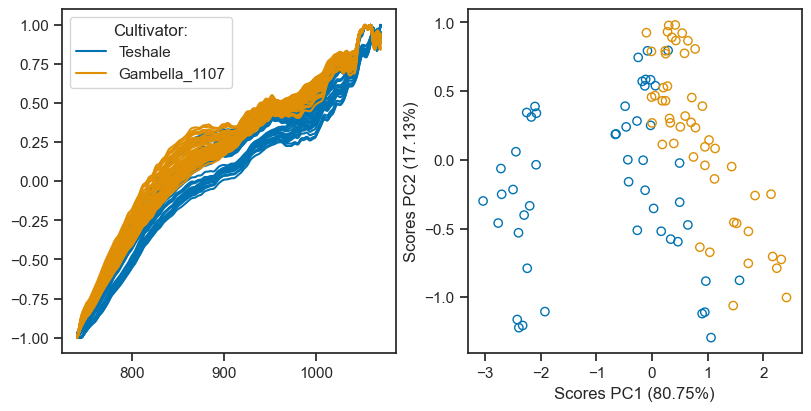

In [194]:
# Your code here
normed_spectra = normalise_spectra(all_spectra)

figure2, axes2 = plt.subplots(constrained_layout=True, ncols=2, figsize=(8, 4))
plot_spectra(data, normed_spectra, wavelengths, cultivators, color_mapping, axes2[0], legend=True)
run_pca_plot_scores(data, normed_spectra, axes2[1], cultivators, color_mapping)

#### Your answer to question 7.1(b): Is there a clear cultivar separation in the scores plot?
*Double click here*

Now there is a better distinction between cultivars for both the spectra plot and the PCA plot. The separation is significantly improved by the normalisation, however, not perfect. 
- In the spectra plot, the *Gambella* cultivator hs in general a higher (normalised) absorbance 
- In the PCA plot, the cultivars are mostly separated along PC1. Also notably is it that the *Teshale* cultivar is separated into two groups in PCA, where one of them is sub-grouped with *Gambella*. 

### 7.1(c)

**Task: Observe the impact of multiplicative scatter correction (MSC) on the spectra and PCA results. In the PCA scores plot, are there any noticeable groupings that suggest cultivar separation?**

**Hint:**
1. Apply the provided MSC function to correct the spectra, for instance,
```python
corrected = multiplicative_scatter_correction(all_spectra)
```
2. Plot the corrected spectra and the corresponding PCA results side-by-side. For instance,
```python
figure3, axes3 = plt.subplots(constrained_layout=True, ncols=2, figsize=(8, 4))
plot_spectra(data, corrected, wavelengths, cultivators, color_mapping, axes3[0])
run_pca_plot_scores(data, corrected, axes3[1], cultivators, color_mapping)
```

In [195]:
def multiplicative_scatter_correction(spectra):
    """
    Applies Multiplicative Scatter Correction (MSC) to the input spectra.

    MSC is a preprocessing technique used to reduce the effects of scatter in spectral data.
    It corrects for variations in path length and particle size, which can affect the
    baseline and slope of the spectra.

    Args:
        spectra (numpy.ndarray): Matrix of spectra, where each row is a spectrum.

    Returns:
        numpy.ndarray: MSC-corrected spectra matrix.
    """

    mean = np.mean(spectra, axis=0)  # Calculate the mean spectrum
    msc_spectra = np.zeros_like(
        spectra
    )  # Initialise an array to store MSC-corrected spectra
    for i, spectrum in enumerate(spectra):
        # Fit a linear regression model to each spectrum against the mean spectrum
        param = np.polyfit(mean, spectrum, 1) #-> [slope, intercept]
        # Apply the MSC correction: (spectrum - intercept) / slope
        msc_spectra[i] = (spectrum - param[1]) / (param[0])
    return msc_spectra

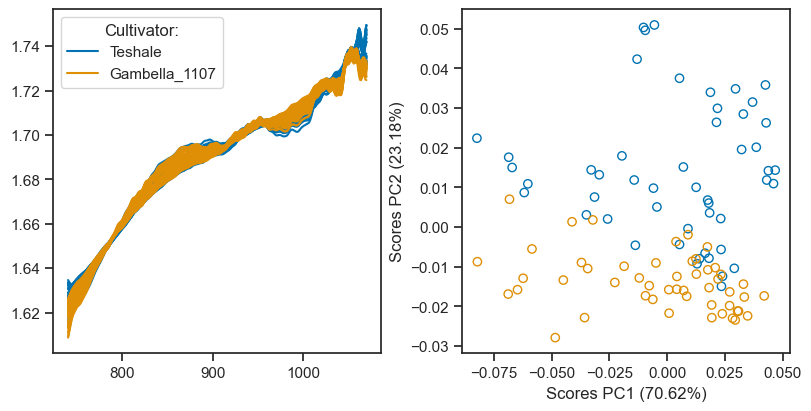

In [196]:
# Your code here

# Apply MSC 
corrected_spectra = multiplicative_scatter_correction(all_spectra)

#Plot the corrected spectra and the corresponding PCA results 
figure3, axes3 = plt.subplots(constrained_layout=True, ncols=2, figsize=(8, 4))
plot_spectra(data, corrected_spectra, wavelengths, cultivators, color_mapping, axes3[0], legend=True)
run_pca_plot_scores(data, corrected_spectra, axes3[1], cultivators, color_mapping)

#### Your answer to question 7.1(c): Is there a clear cultivar separation in the scores plot?
*Double click here*

Even better separation than normalisation, but now mainly along PC2. 

### 7.1(d)

**Task: Investigate the impact of applying a second derivative transformation on the spectra and PCA results. In the PCA scores plot, are there any noticeable groupings that suggest cultivar separation?**

**Hint:**
1. Use the provided code to calculate the second derivative of the original spectra, for instance,

```python
dspectra = derivative(wavelengths, all_spectra, deriv=2)
```
2. Plot the resulting second derivative spectra and the corresponding PCA results side-by-side. For instance,
```python
figure4, axes4 = plt.subplots(constrained_layout=True, ncols=2, figsize=(8, 4))
plot_spectra(data, dspectra, wavelengths, cultivators, color_mapping, axes4[0])
run_pca_plot_scores(data, dspectra, axes4[1], cultivators, color_mapping)
```

**Note:** The derivative is computed using the [Savitzky-Golay filter](https://en.wikipedia.org/wiki/Savitzky%E2%80%93Golay_filter). This method smooths the data by fitting a polynomial to a moving window of points and then calculates the derivative of that fitted polynomial. The method, as implemented here, assumes evenly spaced data points. It may produce inaccurate results if your wavelengths are unevenly spaced. In such cases, alternative methods like B-spline derivatives or other interpolation-based approaches might be more suitable.

In [197]:
def derivative(wavelengths, spectra, window_length=21, polyorder=3, deriv=2):
    """
    Calculates the derivative of the input spectra using the Savitzky-Golay filter.

    This function applies the Savitzky-Golay filter to smooth and differentiate the
    input spectra. The filter is used to reduce noise and enhance spectral features.

    Args:
        wavelengths (numpy.ndarray): Array of wavelengths corresponding to the spectra.
        spectra (numpy.ndarray): Matrix of spectra, where each row is a spectrum.
        window_length (int): The length of the filter window (must be odd).
        polyorder (int): The order of the polynomial used to fit the samples.
        deriv (int, optional): The order of the derivative to compute. Defaults to 2 (second derivative).

    Returns:
        numpy.ndarray: Matrix of derivative spectra.
    """

    derivative = np.zeros_like(
        spectra
    )  # Initialize an array to store derivative spectra

    for i, spectrum in enumerate(spectra):
        # Apply Savitzky-Golay filter to calculate the derivative
        derivative[i] = savgol_filter(
            spectrum,
            window_length,
            polyorder,
            deriv=deriv,
            delta=wavelengths[1] - wavelengths[0],  # Wavelength spacing
            mode="nearest",  # Extrapolation mode at the edges
        )

    return derivative

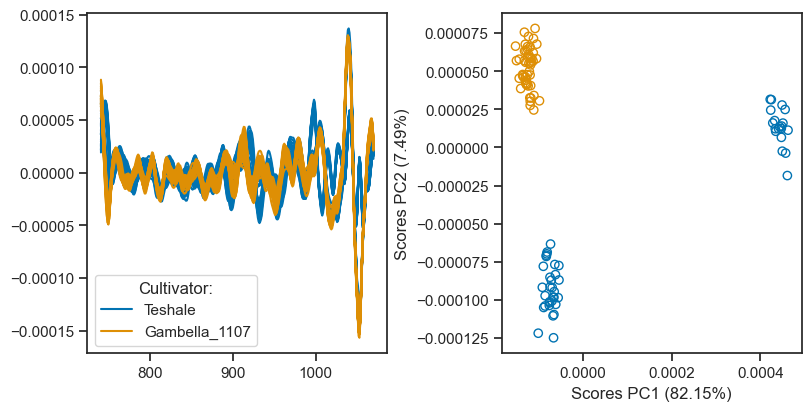

In [198]:
# Your code here

dspectra = derivative(wavelengths, all_spectra, deriv=2)

# Plot the resulting second derivative spectra and the corresponding PCA results 
figure4, axes4 = plt.subplots(constrained_layout=True, ncols=2, figsize=(8, 4))
plot_spectra(data, dspectra, wavelengths, cultivators, color_mapping, axes4[0], legend=True)
run_pca_plot_scores(data, dspectra, axes4[1], cultivators, color_mapping)

#### Your answer to question 7.1(d): Is there a clear cultivar separation in the scores plot?
*Double click here*

Woaw, we here have three very distinct groups, where one is solely from the *Gambella* cultivator anf the two others solely from the *Teshale* cultivator. 

Also notabely, the splitting of *Teshale* into two sub-groups in the PCA plot seen for the normalisation is very clar here. 

### 7.1(e)

**Task: Explain how the Savitzky-Golay filter uses polynomial fitting to smooth data and compute derivatives.**

**Hint:** See page 149 in our text book.

#### Your answer to question 7.1(e): Your explanation for Savitzky-Golay filtering?

*Double click here*

The Savitsky-Golay filtering works by fitting a $k$'th order polynomial ($k \leq N-1$, where $N$ is the number of variables) to a moving window of size $n$ ($n \leq N$). Then the polynomial value at the midpoint in each window is used as the new estimated (smoothened) $y$-value. The derivative is achieved by a simple analytical derivative of the fitted polynomial. 

Funfact: the sequencial polynomial fitting is not done by linear regression or least squares, but by convolution. 

### 7.1(f)

**Task: The figure below displays the results of the preprocessing steps from exercise [7.1(a)](#7.1(a)) to [7.1(d)](#7.1(d)). Based on these results, which preprocessing method appears most promising for building a classifier?**

![Preprocessing NIR results](results7.1.png)

#### Your answer to question 7.1(f): Which preprocessing step appears most promising?
*Double click here*

Definitely the 2nd derivative using a Savitsky-Golay filter followed by PCA. 

## Exercise 7.2

In this exercise, we will smooth and differentiate a noisy signal. We will use a test signal generated from the following analytical function:

$$y(t) = \sin (8t) - 1.8t^2 + 0.5t^3.$$

The noise-free signal data is available in the file [signal.txt](signal.txt). The file contains two columns: the first column represents time ($t$), and the second column represents the signal $y(t)$.

A noisy version of this signal is provided in the file [signal_noise.txt](signal_noise.txt), which also contains two columns: time ($t$) and the signal $y(t)$ with added noise.

The example code below demonstrates how to load and plot the raw data:

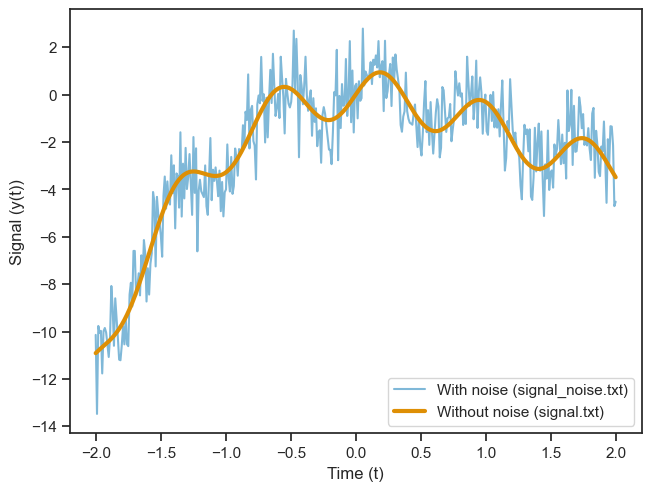

In [199]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_theme(style="ticks", context="notebook", palette="colorblind")

t_clean, y_clean = np.loadtxt("signal.txt", unpack=True)
t_noisy, y_noisy = np.loadtxt("signal_noise.txt", unpack=True)

fig, ax = plt.subplots(constrained_layout=True)
ax.plot(t_noisy, y_noisy, label="With noise (signal_noise.txt)", alpha=0.5)
ax.plot(t_clean, y_clean, label="Without noise (signal.txt)", lw=3)
ax.set(xlabel="Time (t)", ylabel="Signal (y(t))")
ax.legend()

### 7.2(a)

**Task: Smooth the signal with noise using a B-spline. Compare the result to the noise-free signal by plotting both signals.**

**Hint:** You can create the B-spline basis set using the `bbase` function from Eilers and Marx (see the code cell below). You can use this function to create the smoothed signal by completing the following steps:

1. First calculate the B-spline design matrix `X`:
```python
ndx = 20  # Number of B-spline segments
degree = 3  # B-spline degree
X = bbase(t_noisy, ndx=ndx, deg=degree)
```

2. Create the penalty matrix `Dn` (typically, we use D2 or D3 for better interpolation):
```python
n = X.shape[1]
order = 2  # Order of the penalty (1, 2, or 3)
Dn = np.diff(np.eye(n), n=order, axis=0)
```

3. Create the augmented matrix `Xaug` that combines the design matrix `X` obtained from `bbase` with the scaled penalty matrix `sqrt(gamma)*D`, and the augmented column vector `yaug` that combines the y-values from the data set with a vector of zeros equal in length to the number of rows of D:
```python
# Create the augmented matrix Xaug
gamma = 1  # Adjust this to control smoothing
Xaug = np.vstack([X, np.sqrt(gamma) * Dn])
# Create the augmented column vector yaug
yaug = np.concatenate([y_noisy, np.zeros(Dn.shape[0])])
```

4. Find the coefficients that best fit the data set by solving the linear equation `Xaug*beta_hat = yaug`.
```python
# Solve the linear equation Xaug * beta_hat = yaug
beta_hat = np.linalg.lstsq(Xaug, yaug, rcond=None)[0]
```

5. Find the smoothed data `yhat` by calculating `yhat = X*beta_hat`.
```python
# Calculate the smoothed data yhat
y_smooth = X @ beta_hat
```

In [200]:
from scipy.special import factorial


def tpower(x, t, p):
    """Generate degree-p truncated power function."""
    return np.where(x > t, (x - t) ** p, 0.0)


def bbase(x, xl=None, xr=None, ndx=20, deg=3):
    """Construct a B-spline basis of degree `deg`.

    Construct a B-spline basis matrix of a specified degree. This method
    is adapted from:

    Eilers, P.H.C. and Marx, B.D. (2010), Splines, knots, and penalties.
    WIREs Comp Stat, 2: 637-653. https://doi.org/10.1002/wics.125

     Args:
        x: A sequence or array of data points where the basis functions are evaluated.
        xl: The lower boundary for the knots.
        xr: The upper boundary for the knots.
        ndx: The number of intervals between xl and xr.
        deg: The degree of the B-spline.

    Returns:
        A NumPy array representing the B-spline basis matrix.
        Each column is a basis function evaluated at the points in x.
        The shape is (len(x), number_of_basis_functions).

    """
    if xl is None:
        xl = np.min(x)
    if xr is None:
        xr = np.max(x)
    # Generate knot sequence (extends outside boundaries)
    dx = (xr - xl) / ndx
    left = xl - deg * dx
    right = xr + deg * dx
    num_knots = int(round((right - left) / dx)) + 1
    knots = np.linspace(left, right, num_knots)

    # Compute matrix of TPFs
    P = np.zeros((len(x), len(knots)))
    for i in range(len(knots)):
        P[:, i] = tpower(x, knots[i], deg)

    # Compute matrix of b-splines
    n = P.shape[1]
    D = np.diff(np.eye(n), deg + 1, axis=0) / (factorial(deg) * dx**deg)
    B = (-1) ** (deg + 1) * P @ D.T
    return B

In [201]:
# Your code here

# 1. Calculate the B-spline design matrix `X`:
ndx = 20  # Number of B-spline segments
degree = 3  # B-spline degree
X = bbase(t_noisy, ndx=ndx, deg=degree)

# 2. Create the penalty matrix `Dn` (typically, we use D2 or D3 for 
#  better interpolation):
n = X.shape[1]
order = 2  # Order of the penalty (1, 2, or 3)
Dn = np.diff(np.eye(n), n=order, axis=0)

# 3. Create the augmented matrix `Xaug` that combines the design matrix 
#  `X` obtained from `bbase` with the scaled penalty matrix `sqrt(gamma)*D`, 
#  and the augmented column vector `yaug` that combines the y-values from the 
#  data set with a vector of zeros equal in length to the number of rows of D:
# Create the augmented matrix Xaug
gamma = 0.2  # Adjust this to control smoothing
Xaug = np.vstack([X, np.sqrt(gamma) * Dn])
# Create the augmented column vector yaug
yaug = np.concatenate([y_noisy, np.zeros(Dn.shape[0])])

# 4. Find the coefficients that best fit the data set by solving the linear 
#  equation `Xaug*beta_hat = yaug`.
# Solve the linear equation Xaug * beta_hat = yaug
beta_hat = np.linalg.lstsq(Xaug, yaug, rcond=None)[0]

# 5. Find the smoothed data `yhat` by calculating `yhat = X*beta_hat`.
# Calculate the smoothed data yhat
y_smooth = X @ beta_hat

In [202]:
from sklearn.metrics import root_mean_squared_error
rmse = root_mean_squared_error(y_clean, y_smooth)

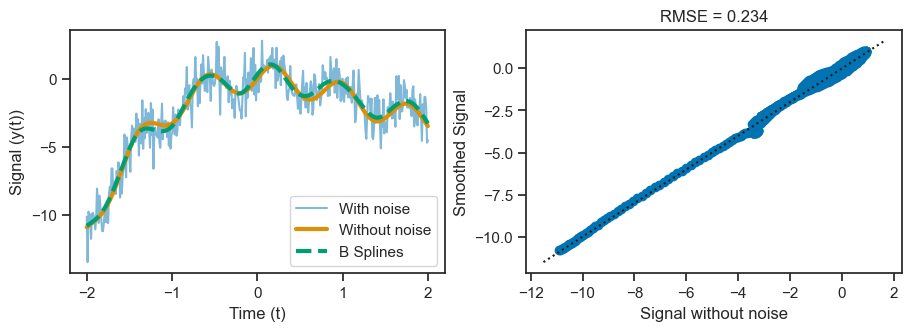

In [203]:
t_clean, y_clean = np.loadtxt("signal.txt", unpack=True)
t_noisy, y_noisy = np.loadtxt("signal_noise.txt", unpack=True)

# Plot signals 
fig, (ax, ax2) = plt.subplots(ncols=2, constrained_layout=True, figsize=(9,3.2))
ax.plot(t_noisy, y_noisy, label="With noise", alpha=0.5)
ax.plot(t_clean, y_clean, label="Without noise", lw=3)
ax.plot(t_noisy, y_smooth, label="B Splines", lw=3, ls='--')
ax.set(xlabel="Time (t)", ylabel="Signal (y(t))")
ax.legend()

# Plot noise-free vs. smoothened 
ax2.scatter(y_clean, y_smooth)
ax2.set(xlabel="Signal without noise", ylabel="Smoothed Signal")
ax2.set_title(f"RMSE = {rmse:.3f}")
# Add the x=y line:
xlim = ax2.get_xlim()
ylim = ax2.get_ylim()

# Calculate the range for the x=y line
min_val = min(min(xlim), min(ylim))
max_val = max(max(xlim), max(ylim))

# Plot the x=y line within the current axes limits
ax2.plot([min_val, max_val], [min_val, max_val], color="k", ls=":")

#### Your answer to question 7.2(a): How does the smoothed signal compare to the noise-free signal?
*Double click here*

Quite well, albeit it over-smoothen the peaks for `gamma > 1`. 

### 7.2(b)

**Task: We could attempt to estimate the derivative of the noisy signal directly using a finite difference approximation, such as the forward difference method:**

$$y'(t_i) \approx \frac{y(t_{i+1}) - y(t_i)}{t_{i+1} - t_i}$$

**Explain the potential problem(s) associated with this approach when applied to a signal containing substantial noise.**

#### Your answer to question 7.2(b): What are the potential problem(s) when using the finite difference approximation directly with a noisy signal?
*Double click here*

In general, the noise will be preserved, and probably, the noise will be amplified because we will have neighbouring points fluctuate in opposite directions (up, down). 

### 7.2(c)

**Task: Calculate the derivative of the smoothed signal from 7.2(a) using the B-spline representation. Compare the derivative to the analytical derivative of the noise-free signal (by plotting both derivatives).**

**Hint:**
1. The analytical derivative of the noise-free signal is:

   $$ y^\prime(t) = 8\cos(8t) - 3.6t + 1.5t^2,$$

   with Python: 
```python
def analytical_derivative(t):
    """Calculate the analytical derivative of the noise-free signal."""
    return 8 * np.cos(8 * t) - 3.6 * t + 1.5 * t**2
```

2. You can find the first derivative of the B-spline using
   ```python
   (1 / h) * X_ @ (D1 @ beta_hat
   ```
   where:
   
   * `h` is the spacing (same as `dx` in `bbase`):
   ```python
   h = (t_noisy.max() - t_noisy.min()) / ndx
   ```
   * `X_` is the design matrix (of degree one less than you used for finding the coefficients `beta_hat`):
   ```python
   X_ = bbase(t_noisy, ndx=ndx, deg=degree-1)
   ```
   
   * `D1` is the first order derivative matrix given by
   ```python
   D1 = np.diff(np.eye(X.shape[1]), n=1, axis=0)
   ```

   Combined example:
```python
h = (t_noisy.max() - t_noisy.min()) / ndx
D1 = np.diff(np.eye(X.shape[1]), n=1, axis=0)
X_ = bbase(t_noisy, ndx=ndx, deg=degree - 1)
derivative_smooth = (1 / h) * X_ @ (D1 @ beta_hat)
```

In [204]:
# Your code here
def analytical_derivative(t):
    """Calculate the analytical derivative of the noise-free signal."""
    return 8 * np.cos(8 * t) - 3.6 * t + 1.5 * t**2

In [205]:
h = (t_noisy.max() - t_noisy.min()) / ndx
D1 = np.diff(np.eye(X.shape[1]), n=1, axis=0)
X_ = bbase(t_noisy, ndx=ndx, deg=degree - 1)
derivative_smooth_BS = (1 / h) * X_ @ (D1 @ beta_hat)

# These will be equal, but still ... 
y_clean_deriv = analytical_derivative(t_clean)
y_noisy_deriv = analytical_derivative(t_noisy)

RMSE = 1.656


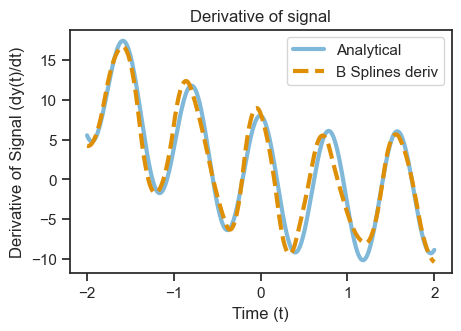

In [206]:
fig, ax1 = plt.subplots(ncols=1, constrained_layout=True, figsize=(4.5,3.2))

# Plot derivative of signals 
ax1.plot(t_noisy, y_noisy_deriv, label="Analytical", alpha=0.5, lw=3) 
ax1.plot(t_noisy, derivative_smooth_BS, label="B Splines deriv", lw=3, ls='--') 
ax1.set(xlabel="Time (t)", ylabel="Derivative of Signal (dy(t)/dt)")
ax1.legend()
ax1.set_title('Derivative of signal')

rmse_BS_dy = root_mean_squared_error(y_clean_deriv, derivative_smooth_BS)
print(f"RMSE = {rmse_BS_dy:.4g}")

#### Your answer to question 7.2(c): How does the computed derivative compare to the analytical derivative?
*Double click here*

Quite good, but somewhat misaligned between -0.5 and 1.5. 

### 7.2(d)

**Task: Smooth the signal and obtain its derivative using a Savitzky-Golay filter. Compare the smoothness and accuracy of both methods (Savitzky-Golay and B-splines) by plotting the results.**

**Hint:** The Savitzky-Golay filter can be applied as follows:
```python
from scipy.signal import savgol_filter

y_smooth_sg = savgol_filter(
    y_noisy,
    window_length=51,  # Length of window to use for smoothing
    polyorder=3,  #  Polynomial order to use.
)

delta_t = t_noisy[1] - t_noisy[0]
derivative_smooth_sg = savgol_filter(
    y_noisy,
    delta=delta_t,  # Sample spacing, needed for the derivative.
    window_length=101,  # Length of window to use for smoothing
    polyorder=3,  #  Polynomial order to use.
    deriv=1,  # Compute the first (1) derivative.
)
# Note: Please experiment with different window lengths and order for the polynomial.
```

In [207]:
from scipy.signal import savgol_filter

In [208]:
# Your code here

params_sg  = []
rmse_sg_y  = [] 
rmse_sg_dy = [] 

for wl in range(20,400): #window length 
    for po in range(1,5): #polynomial order 
        params_sg.append((wl,po))

        y_smooth_sg = savgol_filter(
            y_noisy,
            window_length=wl, 
            polyorder=po, 
        )
        rmse_sg_y.append(root_mean_squared_error(y_noisy, y_smooth_sg))

        delta_t = t_noisy[1] - t_noisy[0]
        dy_smooth_sg = savgol_filter(
            y_noisy,
            delta=delta_t,  # Sample spacing, needed for the derivative.
            window_length=wl, 
            polyorder=po, 
            deriv=1,  # Compute the first (1) derivative.
        )
        rmse_sg_dy.append(root_mean_squared_error(y_noisy_deriv, dy_smooth_sg))


In [209]:
params_sg_opt_y = params_sg[np.argmin(rmse_sg_y)]
print(params_sg_opt_y)
params_sg_opt_dy = params_sg[np.argmin(rmse_sg_dy)]
print(params_sg_opt_dy)

(20, 4)
(81, 4)


In [210]:
delta_t = t_noisy[1] - t_noisy[0]
derivative_smooth_sg = savgol_filter(
            y_noisy,
            delta=delta_t,  # Sample spacing, needed for the derivative.
            window_length = params_sg_opt_dy[0], 
            polyorder = params_sg_opt_dy[1], 
            deriv=1,  # Compute the first (1) derivative.
        )
rmse_sg_dy_opt = root_mean_squared_error(y_clean_deriv, derivative_smooth_sg)

Text(0.5, 1.0, 'Derivative of signal')

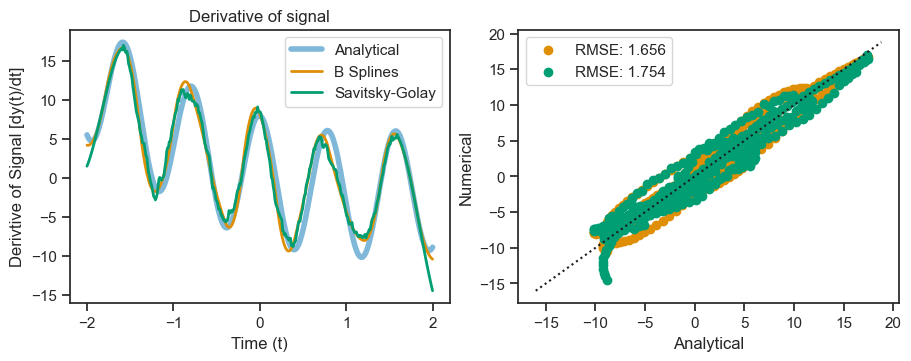

In [213]:
fig, (ax1, ax2) = plt.subplots(ncols=2, constrained_layout=True, figsize=(9, 3.5))

## Plot derivatives 
# Plot analytical derivative   
ax1.plot(t_noisy, y_noisy_deriv, label="Analytical", alpha=0.5, lw=4) 
# Plot B splines derivative 
l_BS, = ax1.plot(t_noisy, derivative_smooth_BS, label="B Splines", lw=2, ls='-') 
# Plot Savitsky-Savgol derivative for best params 
l_SG, = ax1.plot(t_noisy, derivative_smooth_sg, label="Savitsky-Golay", lw=2, ls='-') 

## Plot dy_smooth vs. dy_anlytical
ax2.scatter(y_clean_deriv, derivative_smooth_BS, color=l_BS.get_color(), label=f"RMSE: {rmse_BS_dy:.4g}")
ax2.scatter(y_clean_deriv, derivative_smooth_sg, color=l_SG.get_color(), label=f"RMSE: {rmse_sg_dy_opt:.4g}")
ax2.set(xlabel="Analytical", ylabel="Numerical")
# Add the x=y line:
xlim = ax2.get_xlim()
ylim = ax2.get_ylim()
# Calculate the range for the x=y line
min_val = min(min(xlim), min(ylim))
max_val = max(max(xlim), max(ylim))

# Plot the x=y line within the current axes limits
ax2.plot([min_val, max_val], [min_val, max_val], color="k", ls=":")

## Set labels, titles, etc 
ax1.set(xlabel="Time (t)", ylabel="Derivtive of Signal [dy(t)/dt]")
ax1.legend()
ax2.legend()
ax1.set_title('Derivative of signal')

#### Your answer to question 7.2(d): How do the results from applying the Savitzky-Golay filter compare to the B-splines results
*Double click here*

## Your feedback for Exercise 7

1. **Time & Difficulty:**
* Length (1=too short, 5=too long): 1  2  3  4  5
* Difficulty (1=too easy, 5=too difficult): 1  2  3  4  5
* Most challenging part: ________________________

2. **Code Examples:**
* More or less example code?  More  Less  About Right
* Areas where more examples would be helpful: ________________________

3. **Errors/Inconsistencies:** Did you encounter any?  Yes  No  If yes, please describe: ________________________
    
4. **Suggestions:** How could this exercise be improved? ________________________